## 0. Folder structure

Click to edit me to see structure

📁 data/
│
├── 📁 original/
│   ├── 📁 source_images              # All original phylum_family folders
│   ├── 📁 train                      # Split using same random_state
│   ├── 📁 val
│   └── 📁 test
│
├── 📁 outliers_removed_manual/       # ➤ Approach 1: Manual outlier removal
│   ├── 📁 cleaned_unsplit            # Images after removal, before split
│   ├── 📁 train                      # Split but not yet balanced
│   ├── 📁 val
│   ├── 📁 test
│   └── 📁 train_oversampled_r50_75_100 adptive 1)
│       └── 📄 oversampled_metadata.csv
│
├── 📁 outliers_removed_confidence/   # ➤ Approach 2: Cleanlab-based removal
│   ├── 📁 train
│   ├── 📁 val
│   ├── 📁 test
│   └── 📁 train_oversampled_r50
│       └── 📄 oversampled_metadata.csv


## 1. Data Exploration

In [2]:
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
import os
from PIL import Image

from keras.utils import image_dataset_from_directory

from sklearn.model_selection import train_test_split
import shutil


from tensorflow.keras import Model
from tensorflow.keras.layers import Rescaling, Dense, Resizing, CenterCrop
from tensorflow.keras.applications import MobileNetV2, ResNet50


import tensorflow as tf
from keras.layers import Input, Rescaling, Dense


from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Flatten, Dense, Rescaling, Dropout
from tensorflow.keras.applications import VGG16
from keras.layers import Rescaling, RandAugment
import random


from sklearn.model_selection import StratifiedKFold
from cleanlab.models.keras import KerasWrapperModel


import os
import shutil
import pandas as pd

from PIL import Image, ImageFilter 


Importing function from utils.ipynb

In [3]:
# If you are not able to import the fucntions from utils.py file please restart the kernel and try again
from Library.utils import get_callbacks
from Library.utils import  is_image_empty, is_image_valid, get_image_format, is_aspect_ratio_unusual, check_mode, display_images, display_ranked_label_errors, display_label_errors_for_class_range
from Library.utils import get_all_relative_image_paths, apply_transformations, oversample_adaptive_r5075100

In [4]:
# Check current working directory -- Needs to be DL_project_Group33
os.chdir("/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33")

In [5]:
# Load metadata
metadata_path = 'data//original//source_images//metadata.csv'
metadata = pd.read_csv(metadata_path)

# Verify data loaded correctly
metadata.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-full-si...  
1  chordata_geoemydidae/20969394_793083_eol-full-...  
2  chordata_cryptobranchidae/28895411_319982_eol-...  
3  chordata_turdidae/29658536_45510188_eol-full-s...  
4  chordata_indriidae/21252576_7250886_eol-full-s...

<div style="background-color:rgb(199, 118, 118); border-left: 6px solid red; padding: 10px; margin: 10px 0;">
  <strong>🔴 TO DO:</strong> Add Alex's EDA.
</div>

## 1.1 Data Integrity Checks

Check for number of images

In [6]:
num_images = len(metadata)
print(f"Number of images: {num_images}")

Number of images: 11983


Check if all paths in metadata are valid

In [7]:
# Check if each file listed in metadata actually exists
metadata['full_path'] = 'data/original/source_images/' + metadata['file_path']
metadata['file_exists'] = metadata['full_path'].apply(os.path.exists)

# Summary of missing files
missing_files = metadata[~metadata['file_exists']]
print(f"Missing files count: {len(missing_files)}")
if not missing_files.empty:
    display(missing_files.head())

Missing files count: 0


Check for corrupted images (Can we open all of them)

In [8]:
metadata['is_valid_image'] = metadata['full_path'].apply(is_image_valid)

corrupted = metadata[~metadata['is_valid_image']]
print(f"Number of corrupted images: {len(corrupted)}")

/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33/DL_project_venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Number of corrupted images: 0


Check for duplicate paths

In [9]:
# source: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.duplicated.html
duplicates = metadata[metadata.duplicated(['full_path'], keep=False)]
print(f"Number of duplicate images: {len(duplicates)}")
if not duplicates.empty:
    print("Duplicate images:")
    display(duplicates[['full_path', 'file_path']].head())

Number of duplicate images: 0


Check for empty images (zero-byte files)

In [10]:
metadata['is_empty_image'] = metadata['full_path'].apply(is_image_empty)
empty_images = metadata[metadata['is_empty_image']]
print(f"Number of empty images: {len(empty_images)}")
if not empty_images.empty:
    print("Empty images:")
    display(empty_images[['full_path', 'file_path']].head())

Number of empty images: 0


/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33/DL_project_venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Check format consistency (do we only have jpg files?):

In [11]:
# Check for format consistency
metadata['image_format'] = metadata['full_path'].apply(get_image_format)

# Counts how many images are in each format.
format_counts = metadata['image_format'].value_counts() 

# Display the counts of each format
print("Image format counts:")
print(format_counts)

Image format counts:
image_format
JPEG    11983
Name: count, dtype: int64


/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33/DL_project_venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [12]:
# Check for images with unusual aspect ratios
num_unusual = metadata['full_path'].apply(is_aspect_ratio_unusual).sum()
print(f"Number of images with unusual aspect ratios: {num_unusual}")

Number of images with unusual aspect ratios: 0


/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33/DL_project_venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [13]:
# Get distinct rare species ids
species_ids = metadata['rare_species_id'].unique()
print(f"Number of unique species IDs: {len(species_ids)}")


# Display a sample of the images
sample_species_ids = species_ids[:5]


Number of unique species IDs: 11983


In [14]:
# Understand the structure of the image files
# 1. Each folder name corresponds to phylum_family name

## 1.2 Data Understanding

### General understanding

General structure

Kindgom --> phylum --> family

In [15]:
# Number of unique kingdoms, phyla, and families
kingdom_unique = metadata['kingdom'].unique()
phylum_unique = metadata['phylum'].unique()
family_unique = metadata['family'].unique()
print(f"Number of unique kingdoms: {len(kingdom_unique)}")
print(f"Number of unique phylum: {len(phylum_unique)}")
print(f"Number of unique families: {len(family_unique)}")

Number of unique kingdoms: 1
Number of unique phylum: 5
Number of unique families: 202


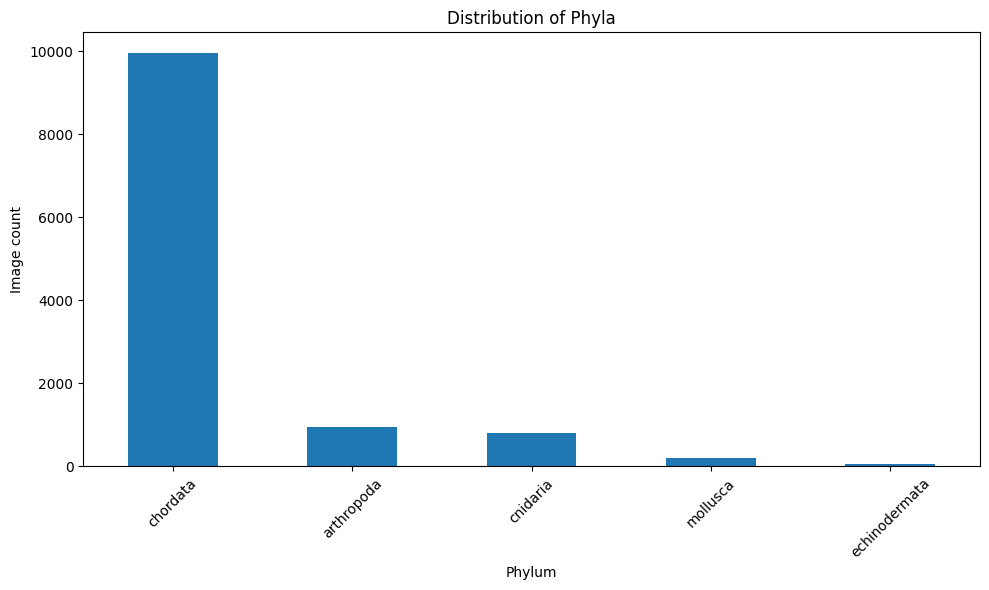

In [16]:
# Bar chart: Number of images per phylum 
plt.figure(figsize=(10, 6))
metadata['phylum'].value_counts().plot(kind='bar')
plt.title('Distribution of Phyla')
plt.xlabel('Phylum')
plt.ylabel('Image count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
# Number of images per kingdom, phylum, and family

# Total number of images
total_images = len(metadata)

# Function to build a summary DataFrame
def build_summary_df(series, label):
    df = series.reset_index()
    df.columns = [label, 'Image Count']
    df['% of Total Images'] = (df['Image Count'] / total_images * 100).round(2)
    return df

# Generate base DataFrames
kingdom_df = build_summary_df(metadata['kingdom'].value_counts(), 'Kingdom')
phylum_df = build_summary_df(metadata['phylum'].value_counts(), 'Phylum')
family_df = build_summary_df(metadata['family'].value_counts(), 'Family')

# Add "% within Phylum" to family_df
# Step 1: Create lookup for phylum per family
family_phylum_map = metadata[['family', 'phylum']].drop_duplicates().set_index('family')['phylum']

# Step 2: Add phylum column to family_df
family_df['Phylum'] = family_df['Family'].map(family_phylum_map)

# Step 3: Get total images per phylum
phylum_image_counts = metadata['phylum'].value_counts()

# Step 4: Calculate % within phylum
family_df['% within Phylum'] = (
    family_df['Image Count'] / family_df['Phylum'].map(phylum_image_counts) * 100
).round(2)

# Optional: Reorder columns
family_df = family_df[['Phylum', 'Family', 'Image Count', '% of Total Images', '% within Phylum']]

display(kingdom_df)
display(phylum_df)
display(family_df)


Kingdom  Image Count  % of Total Images
0  animalia        11983              100.0

Phylum  Image Count  % of Total Images
0       chordata         9952              83.05
1     arthropoda          951               7.94
2       cnidaria          810               6.76
3       mollusca          210               1.75
4  echinodermata           60               0.50

Phylum             Family  Image Count  % of Total Images  \
0      chordata    cercopithecidae          300               2.50   
1      chordata        dactyloidae          300               2.50   
2    arthropoda         formicidae          291               2.43   
3      chordata     plethodontidae          270               2.25   
4      chordata     carcharhinidae          270               2.25   
..          ...                ...          ...                ...   
197    chordata       megapodiidae           30               0.25   
198    chordata       tropiduridae           30               0.25   
199    chordata          parulidae           30               0.25   
200    chordata  brachypteraciidae           30               0.25   
201    chordata          siluridae           29               0.24   

     % within Phylum  
0               3.01  
1               3.01  
2              30.60  
3               2.71  
4               2.71  
..               ...  
197             0.30  
198             0.30  
199             0.30  
200             0.30  
201             0.29  

[202 rows x 5 columns]

### Class imbalance detection for phylums

In [18]:
# Number of families per phylum

# Get number of unique families per phylum
phylum_family_counts = metadata.groupby('phylum')['family'].nunique().reset_index()
phylum_family_counts.columns = ['Phylum', 'Number of Families']

# Calculate total number of families in the entire dataset
total_families = metadata['family'].nunique()

# Add % of total families per phylum
phylum_family_counts['% of Total Families'] = (
    phylum_family_counts['Number of Families'] / total_families * 100
).round(2)

# Add number of images per phylum
phylum_image_counts = metadata['phylum'].value_counts()
phylum_family_counts['Image Count'] = phylum_family_counts['Phylum'].map(phylum_image_counts)

# Sort by image count or number of families
phylum_family_counts = phylum_family_counts.sort_values(by='Number of Families', ascending=False)

# Display
phylum_family_counts


Phylum  Number of Families  % of Total Families  Image Count
1       chordata                 166                82.18         9952
0     arthropoda                  17                 8.42          951
2       cnidaria                  13                 6.44          810
4       mollusca                   5                 2.48          210
3  echinodermata                   1                 0.50           60

> As we can can see from the results above we have a high imbalance of number of images across the different phylums.

> Echinodermata phylum only has 1 family while the chordata phylum has 166 families

Class imbalance detection for families

In [19]:
# Understanding the data

family_df.set_index('Family', inplace=True)
family_df

Phylum  Image Count  % of Total Images  % within Phylum
Family                                                                        
cercopithecidae      chordata          300               2.50             3.01
dactyloidae          chordata          300               2.50             3.01
formicidae         arthropoda          291               2.43            30.60
plethodontidae       chordata          270               2.25             2.71
carcharhinidae       chordata          270               2.25             2.71
...                       ...          ...                ...              ...
megapodiidae         chordata           30               0.25             0.30
tropiduridae         chordata           30               0.25             0.30
parulidae            chordata           30               0.25             0.30
brachypteraciidae    chordata           30               0.25             0.30
siluridae            chordata           29               0.24             0.29

[202 rows x 4 columns]

In [20]:
family_df.describe()

Image Count  % of Total Images  % within Phylum
count   202.000000         202.000000       202.000000
mean     59.321782           0.494406         2.473465
std      54.326637           0.452822         8.282156
min      29.000000           0.240000         0.290000
25%      30.000000           0.250000         0.300000
50%      30.000000           0.250000         0.600000
75%      60.000000           0.500000         1.210000
max     300.000000           2.500000       100.000000

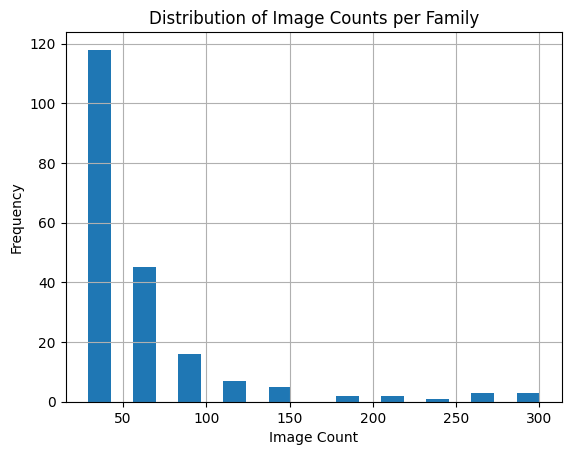

In [21]:
family_df['Image Count'].hist(bins=20)
plt.xlabel('Image Count')
plt.ylabel('Frequency')
plt.title('Distribution of Image Counts per Family')
plt.show()

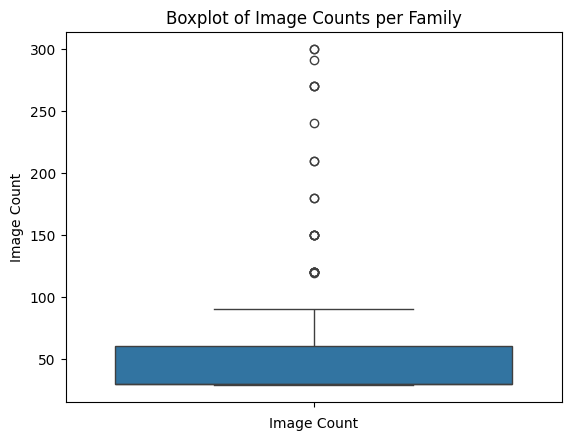

In [22]:
sns.boxplot(family_df['Image Count'])
plt.xlabel('Image Count')
plt.title('Boxplot of Image Counts per Family')
plt.show()

1. Underepresented families
- The minimim value count for images is just one image less than the 50% 
- There doesn't seem to be any underepresented families since the Image count distribution for families seems to be right skewed

2. Overepresented families

- due to the right skewed distribution we will classify overepresented families as families which are above the right bound for outliers (Q3 + 1.5IQR)

Identifying overepresented families

In [23]:
q3 = family_df['Image Count'].quantile(0.75)
q1 = family_df['Image Count'].quantile(0.25)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
upper_bound

105.0

> Considering all the families and differennt phylums, an overepresented family will be considered a family with over 105 images

In [24]:
overepresented_families = family_df.loc[family_df['Image Count'] > upper_bound]
overepresented_families

Phylum  Image Count  % of Total Images  % within Phylum
Family                                                                      
cercopithecidae    chordata          300               2.50             3.01
dactyloidae        chordata          300               2.50             3.01
formicidae       arthropoda          291               2.43            30.60
plethodontidae     chordata          270               2.25             2.71
carcharhinidae     chordata          270               2.25             2.71
salamandridae      chordata          270               2.25             2.71
bovidae            chordata          240               2.00             2.41
bucerotidae        chordata          210               1.75             2.11
acroporidae        cnidaria          210               1.75            25.93
anatidae           chordata          180               1.50             1.81
diomedeidae        chordata          180               1.50             1.81
atelidae           chordata          150               1.25             1.51
laridae            chordata          150               1.25             1.51
apidae           arthropoda          150               1.25            15.77
bufonidae          chordata          150               1.25             1.51
dasyatidae         chordata          150               1.25             1.51
delphinidae        chordata          120               1.00             1.21
agariciidae        cnidaria          120               1.00            14.81
callitrichidae     chordata          120               1.00             1.21
psittacidae        chordata          120               1.00             1.21
spheniscidae       chordata          120               1.00             1.21
iguanidae          chordata          120               1.00             1.21
accipitridae       chordata          119               0.99             1.20

> We have a total of 23 overepresented families

Understanding to which phylum the overepresented families family belong to

In [25]:
overepresented_families['Phylum'].value_counts()

Phylum
chordata      19
arthropoda     2
cnidaria       2
Name: count, dtype: int64

> We can see that most represented families belong to the chordata pylum with a few belonging to the arthropoda and cnidaria

Class imbalance detection for families grouped by Phylum

- By doing this we will be able to locate families that inside their phylum are considered outliers but are not when considering the entire scope
- Able to understand the variability inside each phylum

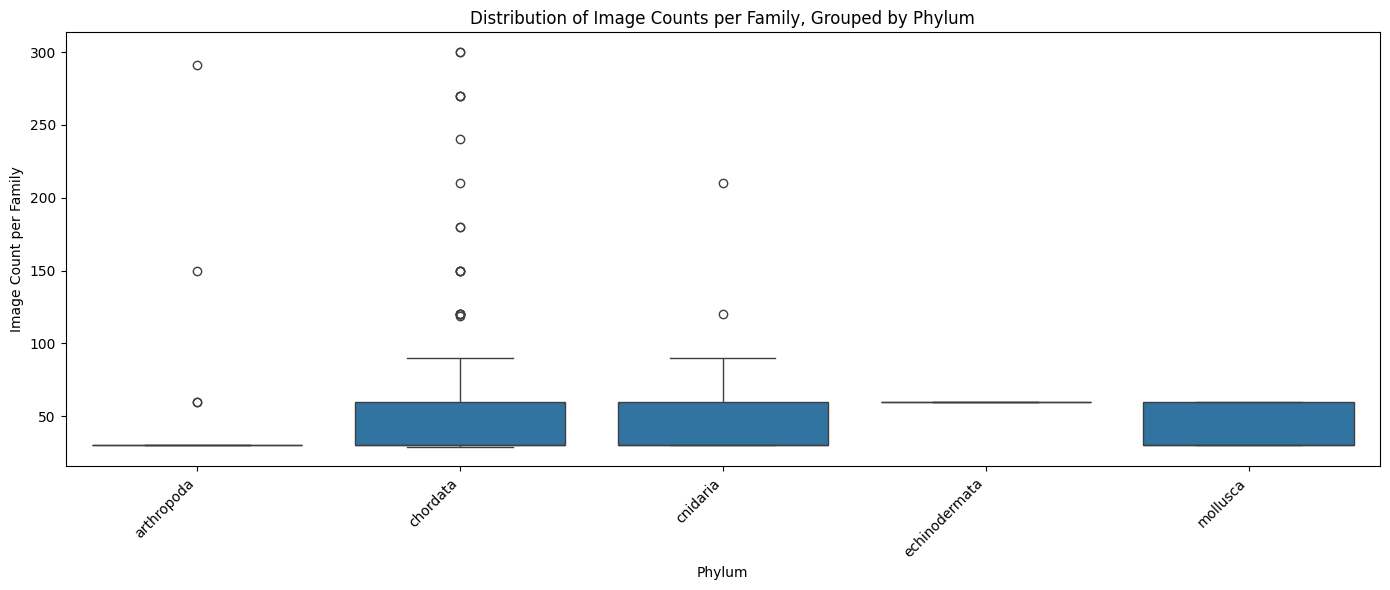

In [26]:
# Prepare the data: image count per family + their phylum
family_image_counts = metadata.groupby(['phylum', 'family']).size().reset_index(name='Image Count')

# Plot: Boxplot of image count per family, grouped by phylum
plt.figure(figsize=(14, 6))
sns.boxplot(data=family_image_counts, x='phylum', y='Image Count')
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Image Counts per Family, Grouped by Phylum')
plt.xlabel('Phylum')
plt.ylabel('Image Count per Family')
plt.tight_layout()
plt.show()


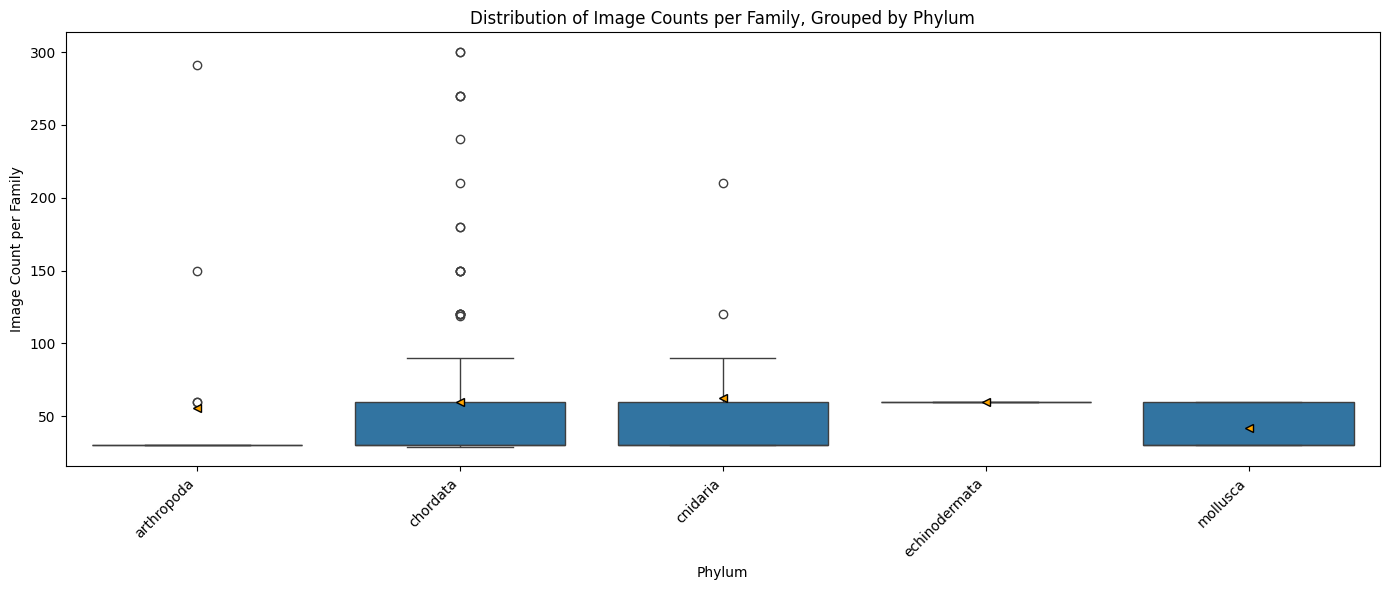

In [27]:
# Prepare the data: image count per family + their phylum
family_image_counts = metadata.groupby(['phylum', 'family']).size().reset_index(name='Image Count')

# Plot: Boxplot of image count per family, grouped by phylum with mean point
plt.figure(figsize=(14, 6))
sns.boxplot(
    data=family_image_counts,
    x='phylum',
    y='Image Count',
    showmeans=True,                     
    meanprops={"marker": "<", "markerfacecolor": "orange", "markeredgecolor": "black"}
)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Image Counts per Family, Grouped by Phylum')
plt.xlabel('Phylum')
plt.ylabel('Image Count per Family')
plt.tight_layout()
plt.show()


> **Conclusions regarding the variability inside each phylum**: As expected chordata (biggest phylum) has the greatest variability in data, having the most extreme outliers (families with very high number of images). Arthopoda and cnidaria are the two next biggest phylums. Even though Arthopoda has more families and more overall images it has less overall variability but a few outliers that might fall below the threshold of 105 (general outliers threshold) that will be inestigated later on. Cnidaria and mollusca offer some variability with only cnidaria having outliers.

Analyzing overepresented families specific for phylum arthropoda

In [28]:
arthropoda_df = family_df[family_df['Phylum'] == 'arthropoda']
q3 = arthropoda_df['Image Count'].quantile(0.75)
q1 = arthropoda_df['Image Count'].quantile(0.25)
iqr = q3 - q1
upper_bound_arthropoda = q3 + 1.5 * iqr
upper_bound_arthropoda

30.0

In [29]:
# Outliers specifc for arthropoda. Means we are looking for a family with more than upper_bound_arthropoda images but less then the upper_bound
family_df.loc[(family_df['Image Count'] > upper_bound_arthropoda) & (family_df['Image Count'] < upper_bound) & (family_df['Phylum'] == "arthropoda")].sort_values('Image Count', ascending=False).head(10)

Phylum  Image Count  % of Total Images  % within Phylum
Family                                                                
carabidae  arthropoda           60                0.5             6.31
gomphidae  arthropoda           60                0.5             6.31

> There are 2 families considered overepresented in the arthropoda phylum regarding the image count.
1. family: carabidae 
2. family: cerambycidae


### Image sizes

Identify common image sizes and outliers.
- Detect images with extreme aspect ratios or inconsistent shapes.

In [30]:
# Detect image size in metadata
metadata['image_size'] = metadata['full_path'].apply(lambda x: Image.open(x).size if os.path.exists(x) else None)

metadata.dtypes 

/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33/DL_project_venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


rare_species_id    object
eol_content_id      int64
eol_page_id         int64
kingdom            object
phylum             object
family             object
file_path          object
full_path          object
file_exists          bool
is_valid_image       bool
is_empty_image       bool
image_format       object
image_size         object
dtype: object

In [31]:
metadata.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  \
0  mollusca_unionidae/12853737_449393_eol-full-si...   
1  chordata_geoemydidae/20969394_793083_eol-full-...   
2  chordata_cryptobranchidae/28895411_319982_eol-...   
3  chordata_turdidae/29658536_45510188_eol-full-s...   
4  chordata_indriidae/21252576_7250886_eol-full-s...   

                                           full_path  file_exists  \
0  data/original/source_images/mollusca_unionidae...         True   
1  data/original/source_images/chordata_geoemydid...         True   
2  data/original/source_images/chordata_cryptobra...         True   
3  data/original/source_images/chordata_turdidae/...         True   
4  data/original/source_images/chordata_indriidae...         True   

   is_valid_image  is_empty_image image_format    image_size  
0            True           False         JPEG    (400, 400)  
1            True           False         JPEG  (1596, 1066)  
2            True           False         JPEG  (2480, 1396)  
3            True           False         JPEG  (1554, 2019)  
4            True           False         JPEG  (1365, 2048)

> As you can see the image size is a tuple. We can split it into two columns: width and height. Doing it below

In [32]:
# Convert image_size tuples into two separate numeric columns
metadata[['image_width', 'image_height']] = pd.DataFrame(metadata['image_size'].tolist(), index=metadata.index)

# Checking datatypes
print(metadata.dtypes[['image_width', 'image_height']])


image_width     int64
image_height    int64
dtype: object


In [33]:
# Check for average image width
metadata['image_width'].describe()

count    11983.000000
mean      1924.600935
std       1267.575315
min        170.000000
25%       1000.000000
50%       1784.000000
75%       2048.000000
max      17000.000000
Name: image_width, dtype: float64

In [34]:
# Check for average image height
metadata['image_height'].describe()

count    11983.000000
mean      1512.260285
std        951.330175
min        125.000000
25%        768.000000
50%       1365.000000
75%       2013.500000
max       8688.000000
Name: image_height, dtype: float64

#### Identify outliers
1. To identify outliers we will use the IQR method
2. In this case we opted to only consider the extreme upper (Q3+ 3*IQR) and extreme lower bounds (Q1 -3*IQR)

Identify outliers in image width 

In [35]:
# Identify outliers in image width
q3_width = metadata['image_width'].quantile(0.75)
q1_width = metadata['image_width'].quantile(0.25)
iqr_width = q3_width - q1_width
upper_bound_width = q3_width + 3 * iqr_width
lower_bound_width = q1_width - 3 * iqr_width
print(f"Upper bound for image width: {upper_bound_width}")
print(f"Lower bound for image width: {lower_bound_width}")

Upper bound for image width: 5192.0
Lower bound for image width: -2144.0


In [36]:
# Identify number of images with width greater than upper bound --> around 12k total images
outlier_width_images = metadata[metadata['image_width'] > upper_bound_width]
print(f"Number of images with width greater than upper bound: {len(outlier_width_images)}")
print(f"% of images with width greater than upper bound: {len(outlier_width_images)/len(metadata) * 100:.2f}%")
# Display outlier images
outlier_width_images[['full_path', 'image_width']].head(10)


Number of images with width greater than upper bound: 280
% of images with width greater than upper bound: 2.34%


full_path  image_width
20   data/original/source_images/chordata_iguanidae...         5472
40   data/original/source_images/chordata_sciuridae...         5472
75   data/original/source_images/arthropoda_gomphid...         9008
97   data/original/source_images/chordata_cebidae/2...         5472
144  data/original/source_images/chordata_sphenisci...         5568
239  data/original/source_images/chordata_chelidae/...         5472
243  data/original/source_images/chordata_carcharhi...         9335
246  data/original/source_images/chordata_nesosping...         5616
343  data/original/source_images/chordata_diomedeid...         5568
400  data/original/source_images/chordata_agamidae/...         6000

In [37]:
# Distribution of global width outliers across phylum

# Obtain distribution of outlier images across phylum
outlier_counts_by_phylum = outlier_width_images['phylum'].value_counts().reset_index()
outlier_counts_by_phylum.columns = ['Phylum', 'Outlier Image Count']


# Add % of outlier images per phylum (relative to total outliers)
total_outliers = len(outlier_width_images)
outlier_counts_by_phylum['% of Outlier Images'] = (
    outlier_counts_by_phylum['Outlier Image Count'] / total_outliers * 100
).round(2)

outlier_counts_by_phylum.set_index('Phylum', inplace=True)

# Display the result
outlier_counts_by_phylum.sort_values(by='Outlier Image Count', ascending=False)


Outlier Image Count  % of Outlier Images
Phylum                                                 
chordata                       269                96.07
arthropoda                       5                 1.79
mollusca                         4                 1.43
cnidaria                         1                 0.36
echinodermata                    1                 0.36

In [38]:
# Distribution of global width outliers across family

outlier_counts_by_family = outlier_width_images['family'].value_counts().reset_index()
outlier_counts_by_family.columns = ['Family', 'Outlier Image Count']

# Add % of outlier images per family (relative to total outliers)
outlier_counts_by_family['% of Outlier Images'] = (
    outlier_counts_by_family['Outlier Image Count'] / total_outliers * 100
).round(2)

outlier_counts_by_family.set_index('Family', inplace=True)

# Display the result
outlier_counts_by_family.sort_values(by='Outlier Image Count', ascending=False)


Outlier Image Count  % of Outlier Images
Family                                                  
diomedeidae                      22                 7.86
spheniscidae                     21                 7.50
plethodontidae                   15                 5.36
mustelidae                       13                 4.64
iguanidae                        11                 3.93
...                             ...                  ...
manidae                           1                 0.36
rhacophoridae                     1                 0.36
falconidae                        1                 0.36
accipitridae                      1                 0.36
alcedinidae                       1                 0.36

[81 rows x 2 columns]

/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33/DL_project_venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


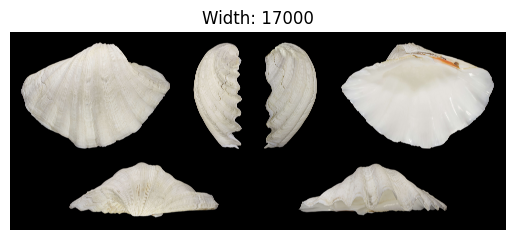

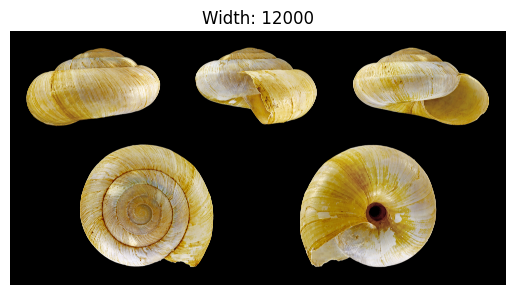

In [39]:
# Display the top two images with biggest width

top2_global_width_outliers = outlier_width_images.sort_values('image_width', ascending=False).head(2)[["full_path", "image_width"]]
for i in top2_global_width_outliers.index:
    img = Image.open(top2_global_width_outliers.loc[i, 'full_path'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Width: {top2_global_width_outliers.loc[i, 'image_width']}")
    plt.show()
    #img.show()


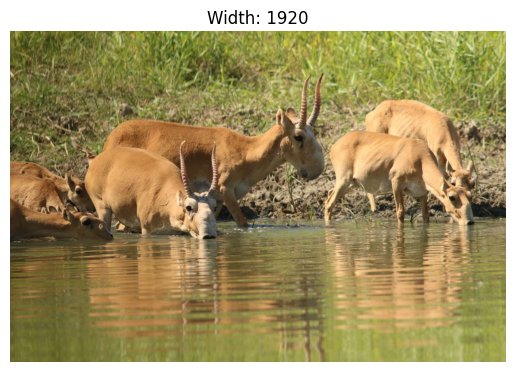

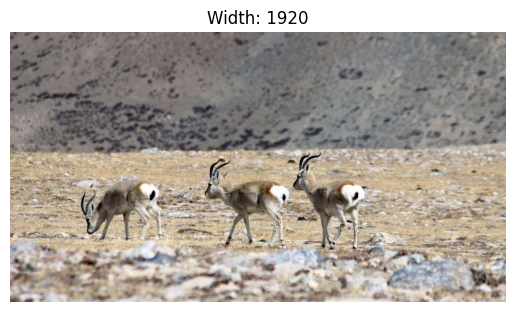

In [40]:
# Display two random images with average width
avg_width = metadata['image_width'].mean()
images_with_avg_width = metadata.loc[(metadata['image_width'] < avg_width + 10) & (metadata['image_width'] > avg_width - 10) ].sample(2)

for i in images_with_avg_width.index:
    img = Image.open(images_with_avg_width.loc[i, 'full_path'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Width: {images_with_avg_width.loc[i, 'image_width']}")
    plt.show()
    #img.show()

Identify outliers in image height 

In [41]:
# Identify outliers in image height
q3_height = metadata['image_height'].quantile(0.75)
q1_height = metadata['image_height'].quantile(0.25)
iqr_height = q3_height - q1_height
upper_bound_height = q3_height + 3 * iqr_height
lower_bound_height = q1_height - 3 * iqr_height
print(f"Upper bound for image width: {upper_bound_height}")
print(f"Lower bound for image width: {lower_bound_height}")

Upper bound for image width: 5750.0
Lower bound for image width: -2968.5


In [42]:
# Identify number of images with height greater than upper bound --> around 12k total images
outlier_height_images = metadata[metadata['image_height'] > upper_bound_height]
print(f"Number of images with height greater than upper bound: {len(outlier_height_images)}")
print(f"% of images with height greater than upper bound: {len(outlier_height_images)/len(metadata) * 100:.2f}%")
# Display outlier images
outlier_height_images[['full_path', 'image_height']].head(10)

Number of images with height greater than upper bound: 38
% of images with height greater than upper bound: 0.32%


full_path  image_height
418   data/original/source_images/chordata_soricidae...          5792
519   data/original/source_images/chordata_dasyatida...          6240
526   data/original/source_images/cnidaria_merulinid...          5792
980   data/original/source_images/chordata_scincidae...          5792
1148  data/original/source_images/chordata_scincidae...          5792
1858  data/original/source_images/arthropoda_tettigo...          6000
1936  data/original/source_images/chordata_hominidae...          6000
2454  data/original/source_images/chordata_soricidae...          5792
2581  data/original/source_images/chordata_viperidae...          6000
2916  data/original/source_images/chordata_soricidae...          5792

In [43]:
# Distribution of global height outliers across phylum
# Obtain distribution of outlier images across phylum
outlier_counts_by_phylum_height = outlier_height_images['phylum'].value_counts().reset_index()
outlier_counts_by_phylum_height.columns = ['Phylum', 'Outlier Image Count']
# Add % of outlier images per phylum (relative to total outliers)
total_outliers_height = len(outlier_height_images)
outlier_counts_by_phylum_height['% of Outlier Images'] = (
    outlier_counts_by_phylum_height['Outlier Image Count'] / total_outliers_height * 100
).round(2)
outlier_counts_by_phylum_height.set_index('Phylum', inplace=True)

print(f"Total number of phylum with outliers: {len(outlier_counts_by_phylum_height)}")
# Display the result
outlier_counts_by_phylum_height.sort_values(by='Outlier Image Count', ascending=False)

Total number of phylum with outliers: 4


Outlier Image Count  % of Outlier Images
Phylum                                              
chordata                     32                84.21
mollusca                      3                 7.89
cnidaria                      2                 5.26
arthropoda                    1                 2.63

In [44]:
# Distribution of global height outliers across family
outlier_counts_by_family_height = outlier_height_images['family'].value_counts().reset_index()
outlier_counts_by_family_height.columns = ['Family', 'Outlier Image Count']
# Add % of outlier images per family (relative to total outliers)
outlier_counts_by_family_height['% of Outlier Images'] = (
    outlier_counts_by_family_height['Outlier Image Count'] / total_outliers_height * 100
).round(2)
outlier_counts_by_family_height.set_index('Family', inplace=True)

print (f"Total number of families with outliers: {len(outlier_counts_by_family_height)}")
# Display the result
outlier_counts_by_family_height.sort_values(by='Outlier Image Count', ascending=False)

Total number of families with outliers: 22


Outlier Image Count  % of Outlier Images
Family                                                  
soricidae                         8                21.05
scincidae                         5                13.16
procellariidae                    3                 7.89
cebidae                           2                 5.26
cardiidae                         2                 5.26
carcharhinidae                    2                 5.26
bucerotidae                       1                 2.63
merulinidae                       1                 2.63
tettigoniidae                     1                 2.63
hominidae                         1                 2.63
viperidae                         1                 2.63
hemiscylliidae                    1                 2.63
ardeidae                          1                 2.63
emydidae                          1                 2.63
dasyatidae                        1                 2.63
diomedeidae                       1                 2.63
zonitidae                         1                 2.63
hexanchidae                       1                 2.63
squalidae                         1                 2.63
ciconiidae                        1                 2.63
acroporidae                       1                 2.63
bombycillidae                     1                 2.63

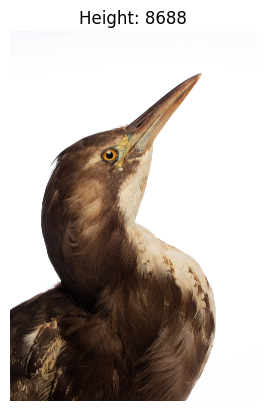

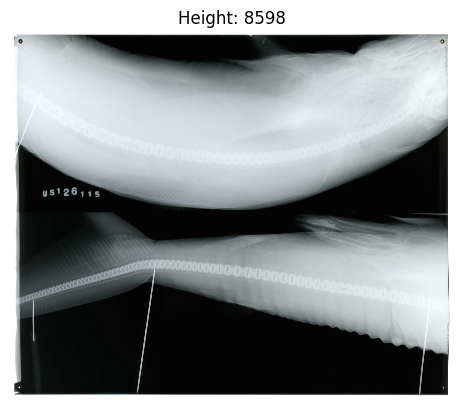

In [45]:
# Display the top two images with biggest height
top2_global_height_outliers = outlier_height_images.sort_values('image_height', ascending=False).head(2)[["full_path", "image_height"]]
for i in top2_global_height_outliers.index:
    img = Image.open(top2_global_height_outliers.loc[i, 'full_path'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Height: {top2_global_height_outliers.loc[i, 'image_height']}")
    plt.show()
    #img.show()

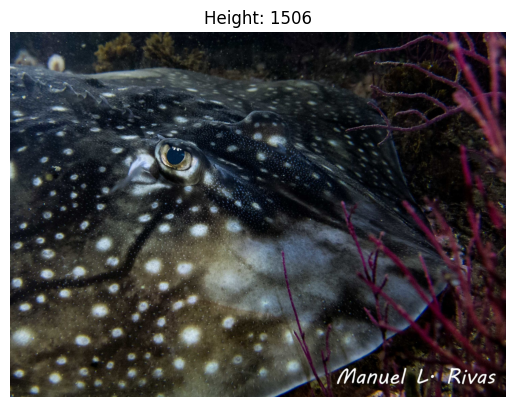

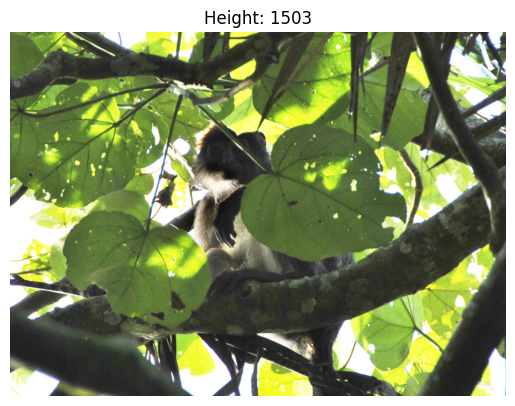

In [46]:
# Display two random images with average height
avg_height = metadata['image_height'].mean()
images_with_avg_height = metadata.loc[(metadata['image_height'] < avg_height + 10) & (metadata['image_height'] > avg_height - 10) ].sample(2)
for i in images_with_avg_height.index:
    img = Image.open(images_with_avg_height.loc[i, 'full_path'])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Height: {images_with_avg_height.loc[i, 'image_height']}")
    plt.show()
    #img.show()

Identify combined outliers in both image height and width

In [47]:
# Identify number of images that are outliers in both dimensions - width and height
width_height_outliers = metadata[
    (metadata['image_width'] > upper_bound_width) &
    (metadata['image_height'] > upper_bound_height)
]

print(f"Images that are outliers in both width and height: {len(width_height_outliers)}")

Images that are outliers in both width and height: 25


In [48]:
# Display the top 10 images with biggest width and height
width_height_outliers[['full_path', 'image_width', 'image_height']].sort_values(['image_width', 'image_height'], ascending=False).head(10)

full_path  image_width  \
10194  data/original/source_images/mollusca_cardiidae...        17000   
6284   data/original/source_images/mollusca_zonitidae...        12000   
7010   data/original/source_images/chordata_carcharhi...        10332   
7121   data/original/source_images/chordata_carcharhi...        10317   
6703   data/original/source_images/chordata_squalidae...         9882   
418    data/original/source_images/chordata_soricidae...         8688   
526    data/original/source_images/cnidaria_merulinid...         8688   
980    data/original/source_images/chordata_scincidae...         8688   
1148   data/original/source_images/chordata_scincidae...         8688   
2454   data/original/source_images/chordata_soricidae...         8688   

       image_height  
10194          6800  
6284           6137  
7010           8598  
7121           6036  
6703           6735  
418            5792  
526            5792  
980            5792  
1148           5792  
2454           5792

Identify number of images evaluated as outliers in terms of values of pixels

In [49]:
#Identify number of images evaluated as outliers in terms of values of pixels
metadata['pixel_count'] = metadata['image_width'] * metadata['image_height']
# Identify outliers in pixel count
q3_pixel = metadata['pixel_count'].quantile(0.75)
q1_pixel = metadata['pixel_count'].quantile(0.25)
iqr_pixel = q3_pixel - q1_pixel
upper_bound_pixel = q3_pixel + 3 * iqr_pixel
lower_bound_pixel = q1_pixel - 3 * iqr_pixel
print(f"Upper bound for pixel count: {upper_bound_pixel}")
print(f"Lower bound for pixel count: {lower_bound_pixel}")

Upper bound for pixel count: 10685832.0
Lower bound for pixel count: -6696624.0


In [50]:
# Identify number of images with pixel count greater than upper bound --> around 12k total images
outlier_pixel_images = metadata[metadata['pixel_count'] > upper_bound_pixel]
print(f"Number of images with pixel count greater than upper bound: {len(outlier_pixel_images)}")
print(f"% of images with pixel count greater than upper bound: {len(outlier_pixel_images)/len(metadata) * 100:.2f}%")

Number of images with pixel count greater than upper bound: 1153
% of images with pixel count greater than upper bound: 9.62%


> Despite using an extreme upper bound for pixel count, we still have too many images being evaluated as outliers 

> Perhaps using a different method to evaluate the number of outliers would be helpful 

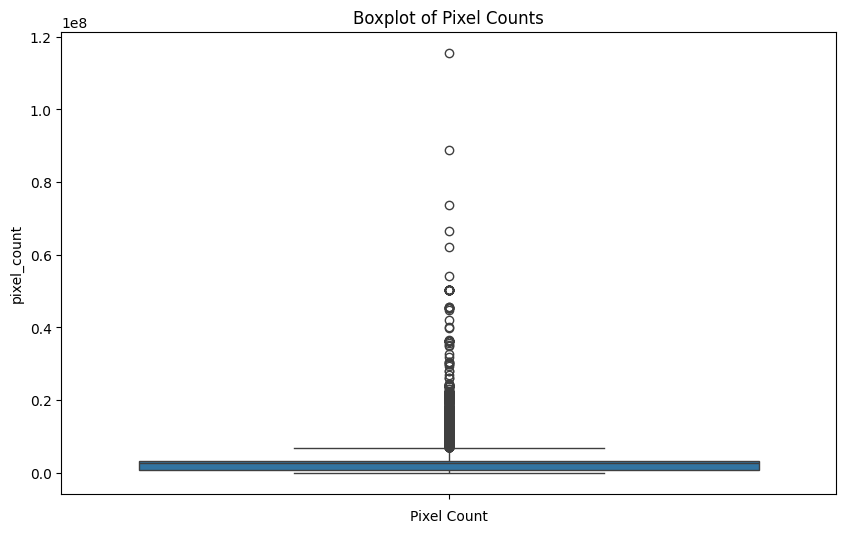

In [51]:
#Plot histogram of pixel count
plt.figure(figsize=(10, 6))
sns.boxplot(metadata['pixel_count'])
plt.xlabel('Pixel Count')
plt.title('Boxplot of Pixel Counts')
plt.show()


### Non-RGB Images

#### Identify the Non-RGB Images

In [52]:
# Check imnage mode

# Apply function to full_path column
metadata['image_mode'] = metadata['full_path'].apply(check_mode)

# Optional: count the different modes
print(metadata['image_mode'].value_counts())


image_mode
RGB     11622
L         183
CMYK      178
Name: count, dtype: int64


/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33/DL_project_venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Visualize L mode images side by side

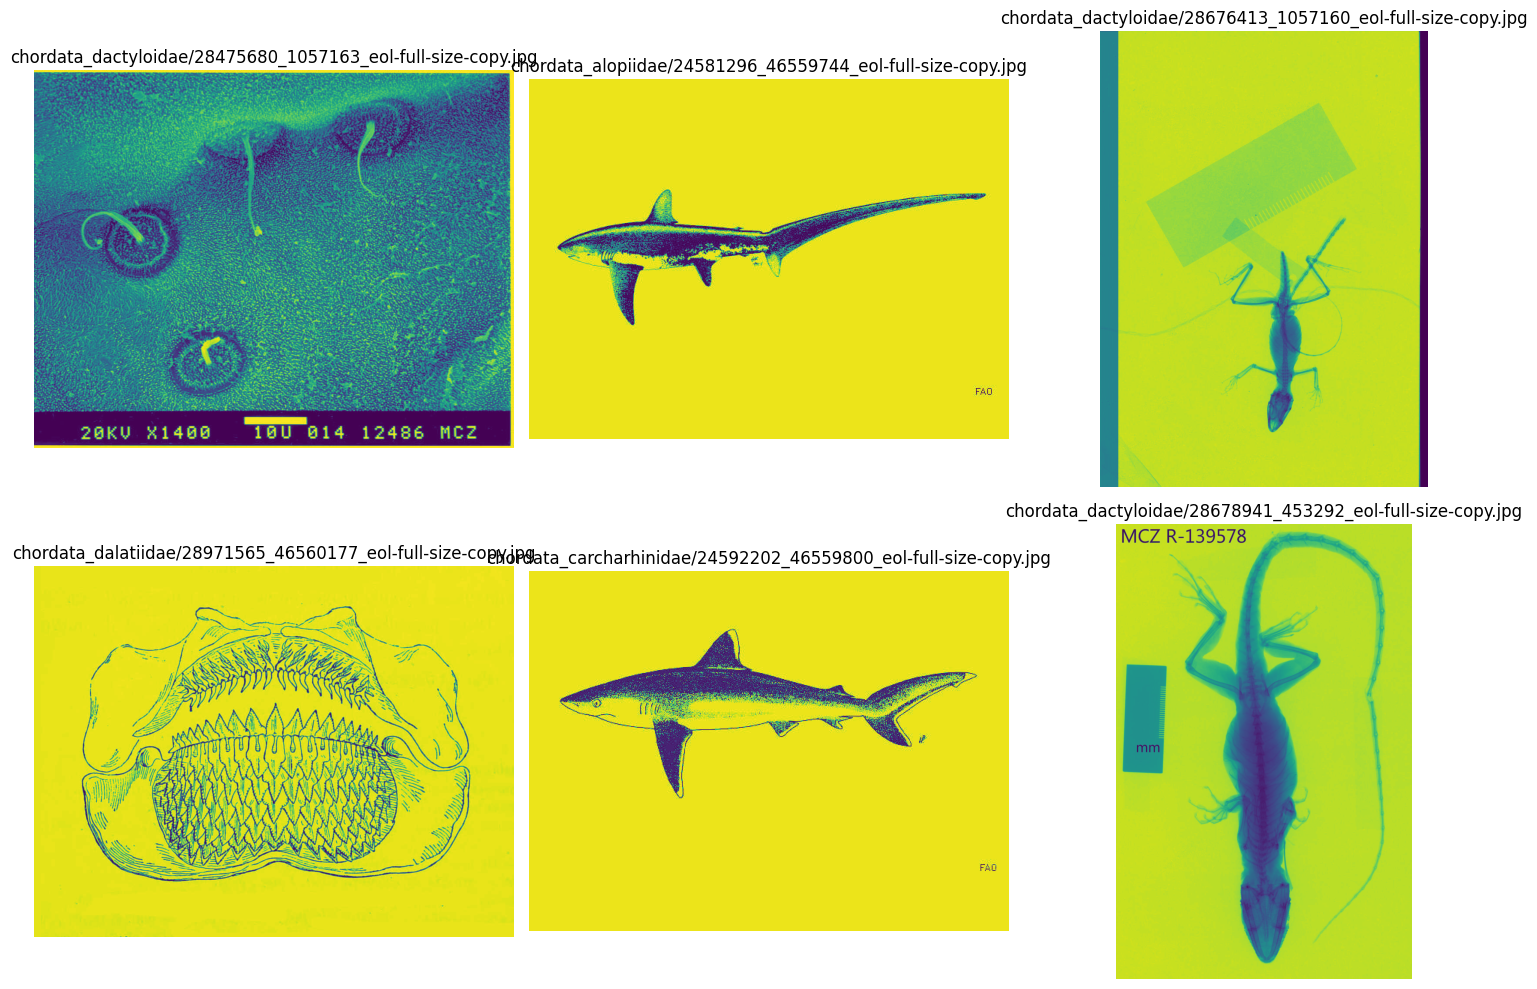

In [53]:
# Filter images with mode 'L'
l_images = metadata[metadata['image_mode'] == 'L']
# Display a sample of L mode images
sample_l_images = l_images.sample(6)
image_paths = sample_l_images['full_path'].tolist()
titles = sample_l_images['file_path'].tolist()
display_images(image_paths, titles)


Visualize CMYK mode images side by side

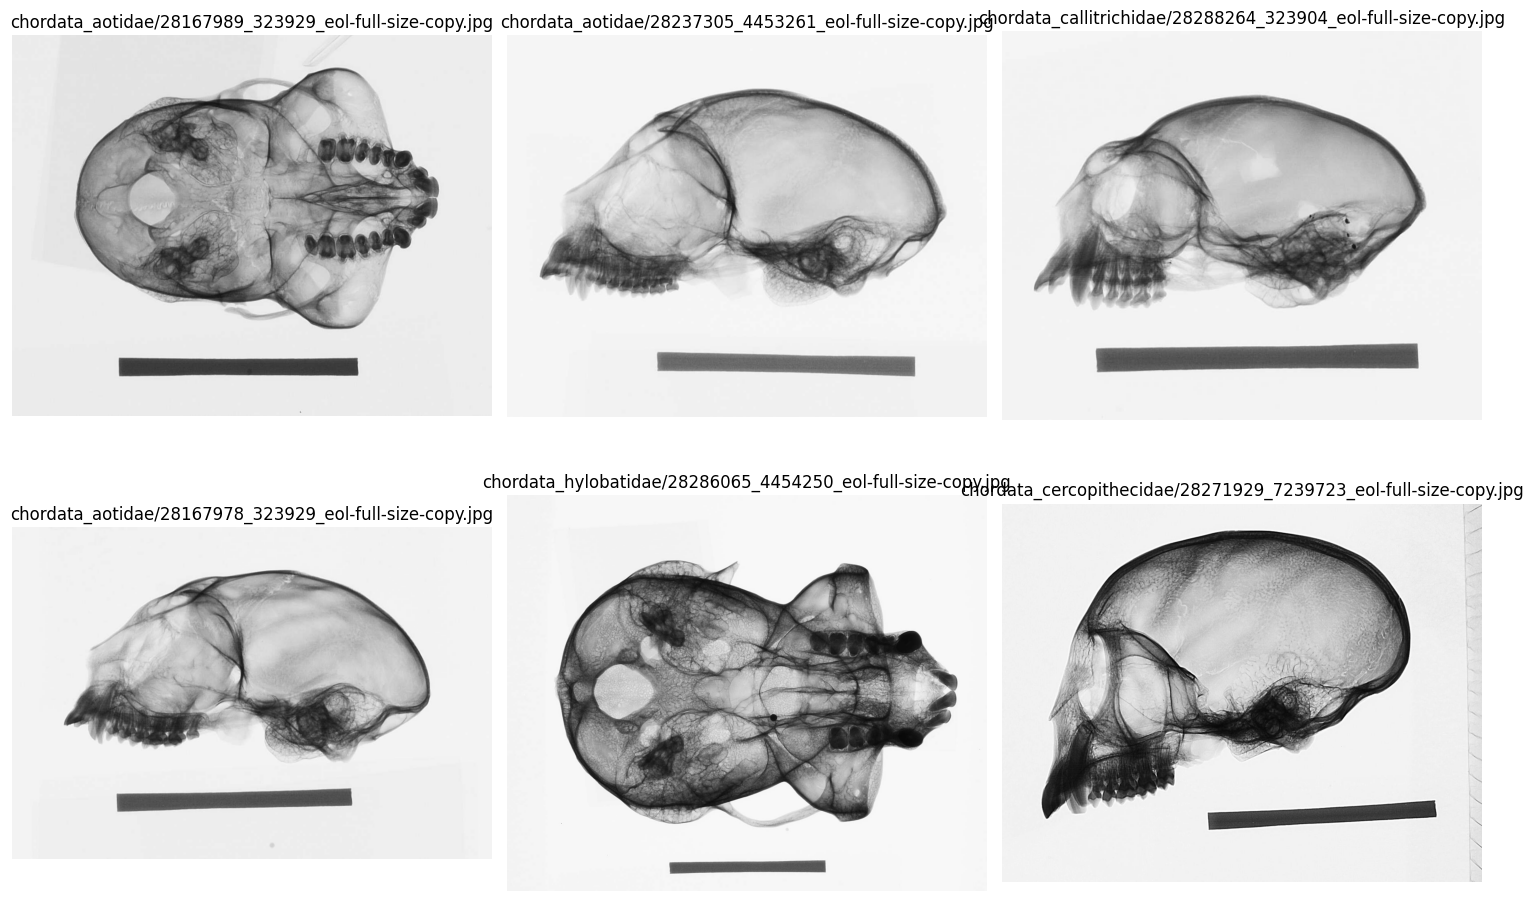

In [54]:
# Filter images with mode 'CMYK'
cmyk_images = metadata[metadata['image_mode'] == 'CMYK']
# Display a sample of L mode images
sample_cmyk_images = cmyk_images.sample(6)
cmyk_image_paths = sample_cmyk_images['full_path'].tolist()
titles = sample_cmyk_images['file_path'].tolist()
display_images(cmyk_image_paths, titles)

#### Convert non RGB images to RGB images

> We can do it when using the image_dataset_from_directory function with color_mode="rgb"

### Identified Issues and Required Actions for Preprocessing (Alex + Joao)

| **Issue**                         | **Description**                                                                 | **Action Required**                                                                                                              | **When to implement it**                                      |
|----------------------------------|----------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------|
| **`1. Class Imbalance`**`             | Some families and phyla dominate in image count                                 | Use class weighting, data augmentation, or sampling strategies                                                                  | **After split** – Needs to be applied only on the training set |
| **2. Non-RGB Images**               | Some images are grayscale or have modes like "L", "P", etc.                     | Convert all images to RGB to standardize model input                                                                            | **After split** – During the loading of training, val and test datasets using the `image_dataset_from_directory` function with color_mode="rgb"       |
| **3. Corrupted or Unreadable Images** | Not an issue                                                                     | No action                                                                                                                       | –                                                             |
| **4. Very Large Images (Pixel Count)** | Some images have extremely high resolution → high memory cost                   | 1. Resize all images with aspect ratio preserved. 2. Apply padding or center-cropping.                       | **Inside the model** – Done by `Resizing()` (with crop_to_aspect_ratio=True or pad_to_aspect_ratio=True)§  |
| **5. High Variability in Dimensions** | Lots of different resolutions and aspect ratios                                 | 1. Resize all images with aspect ratio preserved. 2. Apply padding or center-cropping.                                          | **Inside the model** – Done by `Resizing()` (with crop_to_aspect_ratio=True or pad_to_aspect_ratio=True)           |
| **6. Unusual Aspect Ratios**        | Some images are much taller or wider than typical                               | 1. Resize all images with aspect ratio preserved. 2. Apply padding or center-cropping.                                          | **Inside the model** – Done by `Resizing()` (with crop_to_aspect_ratio=True or pad_to_aspect_ratio=True)|
| **7. Brightness and Exposure Variation** | Some images are too dark or washed out                                         | Apply brightness/contrast normalization (optional)                                                                             | **During training only** – As part of data augmentation        |
| **`8. Noise label images`**      | Some images are not correctly representative of the phylum_family classes they are in | Consider removing or labeling separately if they harm generalization                                                           | **Before split** – Ensures training and evaluation consistency |
| **9. Metadata-Image Mismatches**    | (Not an issue) Some files in metadata don’t exist, or vice-versa               | No action                                                                                                                       | –                                                             |
| **10. Pixel Intensity Scaling**      | 1. Raw pixel values are in [0, 255] 2. Feeding those into a model can cause issues | Normalize pixel values to range [0, 1]                                                                                          | **Inside the model** – Done automatically by `Rescaling()`     |


## 2. Preprocessing stage

### 2.1 Spliting data into train, val and test datasets


Click to edit me (see structure)

├── 📁 original/
│   ├── 📁 source_images              # All original phylum_family folders
│   ├── 📁 train                      # Split using same random_state
│   ├── 📁 val
│   └── 📁 test

In [55]:
# Using stratufy to maintain the distribution of classes in the train, validation, and test sets
train_df, val_test_df = train_test_split(metadata, test_size=0.3, stratify=metadata['family'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['family'], random_state=42)

In [56]:
# Create folder structure and move/copy images
## source https://www.kaggle.com/discussions/general/111208

def move_images(df, folder_name, original_base_dir, target_base_dir):
    for _, row in df.iterrows():
        src_path = os.path.join(original_base_dir, row['file_path'])  # e.g., "arthropoda_apidae/image1.jpg"
        subfolder = os.path.dirname(row['file_path'])  # e.g., "arthropoda_apidae"
        dst_dir = os.path.join(target_base_dir, folder_name, subfolder)
        dst_path = os.path.join(dst_dir, os.path.basename(src_path))

        os.makedirs(dst_dir, exist_ok=True)

        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"Missing file: {src_path}")

In [57]:
# Set the base directory for the original images (inside source images folder)
original_base_dir = 'data/original/source_images'

# Set the base directory for the destination folders
target_base_dir = 'data/original'

# Create directories for each split
os.makedirs(os.path.join(target_base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'test'), exist_ok=True)

# Move images to their corresponding folders
move_images(train_df, 'train', original_base_dir, target_base_dir)
move_images(val_df, 'validation', original_base_dir, target_base_dir)
move_images(test_df, 'test', original_base_dir, target_base_dir)


###  2.2 Dealing with outlier images

1. In this section, we will explain our strategy to deal with images that are clearly mismatched or not semantically aligned with their labeled phylum_family category
2. These can hurt model performance specially with pre-trained models
3. The model might learn to associate certain features with the wrong labels
4. To tackle this issue we will use two approaches 1) Confidence Learning Methodology (paper backed) 2) Manual removal of outliers

<div style="background-color:rgb(199, 118, 118); border-left: 6px solid red; padding: 10px; margin: 10px 0;">
  <strong>🔴 TO DO:</strong> Explain why applying the outlier removal approaches before the data split does not incurre in data leakage. Check 17.04 meeting notes for justification.
</div>

#### Approach 1. Confidence Learning methodology
##### 1. Overview 
1. Confidence Learning (CL) is a data-centric framework for handling noisy labels in datasets. Its core ideas are:

2. Joint Distribution Estimation: CL estimates the joint distribution between the (noisy) observed labels and the (unknown) true labels using out‐of‐sample predicted probabilities. These probabilities are typically derived from a classifier (e.g., a CNN with a softmax output).

3. Class-Conditional Noise Assumption: It assumes that label noise is class-conditional—that is, the probability of a label being incorrect depends mainly on the class rather than the specific input features.

4. Thresholding & Ranking: By comparing predicted class probabilities (from out‐of‐sample predictions) with the given labels, CL uses per‑class thresholding to identify examples whose predictions are highly inconsistent with their assigned labels. The method then ranks these examples (by “self_confidence” or normalized margin) to flag likely label errors.

5. Model-Agnostic: Although the paper uses neural networks (and often a ResNet-type architecture) to generate probabilities, CL is designed to work with any classifier that outputs a probability distribution.

6. Key Requirement – Out‑of‑Sample Predictions:
- A critical component of CL is that it must use out-of-sample predicted probabilities. This means the predicted probabilities for each sample should be generated by a model that has not been trained on that particular sample. This approach avoids overfitting—where a model might be overly confident (and incorrectly so) on the training data—and instead provides unbiased estimates of uncertainty.

- Why Needed? In-sample predictions are often overconfident because the model may memorize the training data (including its noise), leading to unreliable probability estimates. By contrast, out-of-sample predictions (e.g., via cross-validation) ensure that each prediction better reflects the model’s uncertainty and can reveal true mismatches between the visual content and the assigned label.


(Reference: Northcutt et al., "Confident Learning: Estimating Uncertainty in Dataset Labels") -  https://arxiv.org/abs/1911.00068



##### 2. Clean Lab package

The Cleanlab package is built upon the principles of Confidence Learning. Specifically:

1. Implementation of CL: Cleanlab provides functions (such as find_label_issues()) that implement the CL algorithms. It calculates quantities like the "confident joint" based on the predicted probabilities and uses thresholding to determine which labels are likely erroneous.

2. Model-Agnostic Data Cleaning: Cleanlab works with any model that outputs class probabilities. Whether you use a lightweight CNN in Keras or any other classifier, Cleanlab uses the model’s predictions to flag label issues, enabling you to clean the dataset before training your final model.

3. Experimental Utility: The Cleanlab package is designed to be integrated into a typical machine learning workflow. For image datasets, it accepts predicted probabilities (from out-of‑sample predictions, ideally obtained via cross‑validation) and outputs a ranking of the samples with suspected label errors. This ranking can then guide manual inspection and removal of errors.

References: 
1) https://cleanlab.ai/blog/label-errors-image-datasets/ 
2) https://docs.cleanlab.ai/stable/cleanlab/models/keras.html#module-cleanlab.models.keras
3) https://github.com/cleanlab/cleanlab/tree/master/cleanlab

##### Approach to remove noisy label images

1. Identify images that are most likely to be label errors using the Clean Lab Package
2. Select top X for manual review and potential removal

##### Experimenting methodology with smaller subset of data 
##### Creating subset of data with only 5 phylum_family folders

In [ ]:
"""

# Set the source and destination
source_dir = 'data'  # original folder with 202 class subfolders
dest_dir = 'data_subset'  # new folder for 10 random classes

# Create the destination directory if it doesn't exist
os.makedirs(dest_dir, exist_ok=True)

# Get all class subfolders
all_classes = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

# Randomly select n classes
num_selected_classes = 5
selected_classes = random.sample(all_classes, num_selected_classes)
print("Selected classes:", selected_classes)

# Copy each selected class folder
for class_name in selected_classes:
    src_path = os.path.join(source_dir, class_name)
    dst_path = os.path.join(dest_dir, class_name)
    shutil.copytree(src_path, dst_path)

print("✅ 5 random classes copied to 'data_subset/'")
"""

##### Step 1: Load all labeled data

In [ ]:
"""
dataset = image_dataset_from_directory(
    'data_subset',                  
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=32,
    interpolation='bilinear',
    shuffle=True
)

class_names = dataset.class_names
num_classes = len(class_names)
"""

##### Step 2: Convert to NumPy arrays (X, y)

In [ ]:
"""
# We need to convert the dataset to numpy arrays for cleanlab. It requires the data to be in numpy format.
# source: https://stackoverflow.com/questions/63513478/low-level-tensorflow-dataset-as-numpy-iterator-returns-dicts-instead-of-numpy
X_list, y_list = [], []

for images, labels in dataset.as_numpy_iterator(): # to avoid loading all images into memory at once. 
    X_list.append(images)
    y_list.append(labels)

X = np.concatenate(X_list)
y = np.concatenate(y_list)

"""

##### Step 3. Define the model 

Why did we select the `MobileNetV2` architecture as our pre trained model?
1. Based on the model comparison table in the Keras documentation (https://keras.io/api/applications/), achieves a competitive top-1 accuracy while having fewer parameters and faster inference times
2. Hence MobileNetV2 provides sufficiently strong performance for our task while being computationally efficient.

In [ ]:
# Defining the callbacks
#callbacks = get_callbacks(
 #   base_dir="model_logs/Preprocessing_Outliers_VGG16_Image_subset"
#)

Need to talk about
- why using VGG16
- WHy using augmntation
- Why using drop out
- why using image nets weights
- why using input shape of 224,224

In [ ]:
"""
# Define the model

def build_augmented_vgg16(input_shape=(224, 224, 3), num_classes=10, value_range=(0.0, 1.0), dropout_rate=0.3):
    inputs = Input(shape=input_shape)

    # Preprocessing
    x = Rescaling(1. / 255)(inputs)
    x = RandAugment(value_range=value_range)(x)

    # Backbone
    base_model = VGG16(include_top=False, weights="imagenet", input_shape=input_shape)
    x = base_model(x)

    # Classifier
    x = Flatten()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

"""


##### Step 4. Train the model 

In [ ]:
"""
# Convert one-hot encoded labels to integer labels
y_int = np.argmax(y, axis=1)

pred_probs = np.zeros((len(X), num_classes))  # To store OOS predicted probabilities

skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X, y_int):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train = y[train_idx]  # you can still use the one-hot version for training if needed

    clf = KerasWrapperModel(
    model=build_augmented_vgg16,
    model_kwargs={'input_shape': (224, 224, 3), 'num_classes': num_classes},
    compile_kwargs={
        'optimizer': 'adam',
        'loss': 'categorical_crossentropy',  # Changed from sparse_categorical_crossentropy
        'metrics': ['accuracy', 'precision', 'recall']

    }
    )

    clf.fit(X_train, y_train, epochs=15, batch_size=32, verbose=1,callbacks=callbacks, validation_data=(X_val, y[val_idx]))

    # Even if kernel restarts we can just reload it from saved model
    preds = clf.predict_proba(X_val)
    pred_probs[val_idx] = preds
"""


##### Step 5: Use Cleanlab to Identify Label Issues

In [ ]:

"""
from cleanlab.filter import find_label_issues

# Find label issues using the predicted probabilities
ranked_label_issues = find_label_issues(
    labels=y_int,
    pred_probs=pred_probs,
    return_indices_ranked_by="self_confidence"
)

print(f"Found {len(ranked_label_issues)} potential label issues.")
print("Here are the indices of the top 15 most likely label errors:\n"
      f"{ranked_label_issues[:15]}")

      
"""

In [ ]:
"""
# Display the top 15 most likely label errors
display_ranked_label_errors(X, y_int, pred_probs, class_names, ranked_label_issues, n=15)

"""

##### Experimenting methodology on entire dataset


##### Step 1: Load all labeled data

In [ ]:
"""
# Load the full dataset
full_dataset = image_dataset_from_directory(
    'data/original/source_images',  # Path to the full dataset                    
    labels='inferred',
    label_mode='categorical',         
    color_mode='rgb',
    image_size=(224, 224),
    batch_size=32,
    interpolation='bilinear',
    shuffle=True                      # For initial loading, you can shuffle or disable for consistency
)

class_names = full_dataset.class_names
num_classes = len(class_names)
print("Class names:", class_names)
"""


##### Step 2: Convert to NumPy arrays (X, y)

In [ ]:
"""
X_list_full, y_list_full = [], []

for images, labels in full_dataset.as_numpy_iterator(): # to avoid loading all images into memory at once. 
    X_list_full.append(images)
    y_list_full.append(labels)

X_full = np.concatenate(X_list_full)
y_full = np.concatenate(y_list_full)
"""


##### Step 3. Define the model 

Why did we select the `ResNet50` architecture as our pre trained model?
1. Based on the model comparison table in the Keras documentation (https://keras.io/api/applications/), ResNet50 consistently achieves strong top-1 accuracy and is widely used as a robust baseline for image classification tasks.

2. ResNet50’s residual connections make it particularly effective for training deeper models and capturing complex image features, which is valuable for identifying potential label issues in the confidence learning approach.

Why are we using the Functional API method and not the class method to design our model?
1. We do it to create a model that is cloneable and compatible with Cleanlab’s wrappers.
2. Cleanlab’s wrappers is a scikit‑learn tool that relies on being able to clone the model, which is easier to do with a function that returns a functional or Sequential model

In [ ]:
"""
# Define the model
def build_model(input_shape=(224, 224, 3), num_classes=num_classes):
    inputs = Input(shape=input_shape)
    x = Rescaling(1. / 255)(inputs)
    x = ResNet50(include_top=False, pooling='avg', weights='imagenet')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)
    
    """


##### Step 4. Train the model 

In [ ]:
"""
# Defining the callbacks
callbacks = get_callbacks(
base_dir="model_logs/Preprocessing_Outliers_ResNet50_all_data"
)
"""

In [ ]:
"""
# Convert one-hot encoded labels to integer labels
y_int_full = np.argmax(y_full, axis=1)
"""

In [ ]:
"""
# To store out-of-sample (OOS) predicted probabilities
pred_probs = np.zeros((len(X_full), num_classes))

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_full, y_int_full):
    X_train, X_val = X_full[train_idx], X_full[val_idx]
    y_train = y_full[train_idx]  # Can still be one-hot encoded

    # Build and wrap model
    clf = KerasWrapperModel(
        model=build_model,
        model_kwargs={
            'input_shape': (224, 224, 3),
            'num_classes': num_classes
        },
        compile_kwargs={
            'optimizer': 'adam',
            'loss': 'categorical_crossentropy',
            'metrics': ['accuracy', 'precision', 'recall']
        }
    )

    # Train the model
    clf.fit(
        X_train,
        y_train,
        epochs=12,
        batch_size=32,
        verbose=1,
        callbacks=callbacks,  # <– assumes you already defined this
        validation_data=(X_val, y_full[val_idx])
    )

    # Predict probabilities for validation fold and store
    preds = clf.predict_proba(X_val)
    pred_probs[val_idx] = preds



# ✅ Save after all folds are done
output_path = "model_logs/Preprocessing_Outliers_ResNet50_all_data/pred_probs.npy"
np.save(output_path, pred_probs)
"""


In [ ]:
"""
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)

# 1. Convert predicted probabilities to predicted labels via argmax
predicted_labels = pred_probs.argmax(axis=1)

# 2. Basic Accuracy
acc = accuracy_score(y_int_full, predicted_labels)
print(f"Accuracy: {acc:.3f}")

# 3. Precision, Recall, F1 (macro-averaged, but you can also use 'weighted' or 'micro')
prec = precision_score(y_int_full, predicted_labels, average='macro')
rec = recall_score(y_int_full, predicted_labels, average='macro')
f1 = f1_score(y_int_full, predicted_labels, average='macro')

print(f"Precision (macro): {prec:.3f}")
print(f"Recall (macro):    {rec:.3f}")
print(f"F1 Score (macro):  {f1:.3f}")

# 4. Classification Report (shows per-class performance)
print("Classification Report:")
print(classification_report(y_int_full, predicted_labels, target_names=class_names))
"""

> As we can see the model is not performing well with an overall accuracy of around 0.039 and an F1 Score (macro of 0.008)

> Even though the results are quite poor, the helper model is just being used to identify potential label errors with the out of sample predicted probabilities

> Considering the goal of this stage and that we are still not in the modeling stage, we can still use the predicted probabilities to find label errors

<div style="background-color:rgb(199, 118, 118); border-left: 6px solid red; padding: 10px; margin: 10px 0;">
  <strong>🔴 TO DO:</strong> Explain that because the model results are bad and to avoid wasting computational resources in more preprocessing we decided to use manual approach.
</div>

##### Step 5: Use Cleanlab to Identify Label Issues

In [ ]:
"""

from cleanlab.filter import find_label_issues

# Find label issues using the predicted probabilities
ranked_label_issues = find_label_issues(
    labels=y_int_full,
    pred_probs=pred_probs,
    return_indices_ranked_by="self_confidence"
)

print(f"Found {len(ranked_label_issues)} potential label issues.")
print("Here are the indices of the top 15 most likely label errors:\n"
      f"{ranked_label_issues[:15]}")


"""


In [ ]:
"""
# Visualize the top n images with the most likely label errors
# Display the top 15 most likely label errors
display_ranked_label_errors(X_full, y_int_full, pred_probs, class_names, ranked_label_issues, n=200)
"""

Understanding the obtained results

For each image \( x_k \) with a provided (noisy) label \( y_k \), your model (via cross-validation) produces a probability vector:

$$
\hat{p}(y \mid x_k) = \big[\hat{p}(y=0 \mid x_k),\ \hat{p}(y=1 \mid x_k),\ \dots,\ \hat{p}(y=201 \mid x_k)\big].
$$

**Self-confidence** for that image is defined as the **predicted probability assigned to its provided label**.  
For instance, if the provided label (the "true" label from your dataset) for \( x_k \) is class \( i \), the self-confidence is:

$$
\text{Self-confidence} = \hat{p}(y = i \mid x_k).
$$

- A **high self-confidence** (e.g., 0.20) means the model is very confident that the image belongs to the provided label.
- A **low self-confidence** (e.g., 0.02) suggests that the model doubts the label—this image is likely to be mislabeled or semantically mismatched.







Function to determine the top n label error images for each class

In [ ]:
"""
# Display the top 10 label error images for each class in the range of 0 to 3
display_label_errors_for_class_range(
    X_full, 
    y_int_full, 
    pred_probs, 
    class_names, 
    ranked_label_issues, 
    start=190, 
    end=193, 
    n=10
)
"""

In [ ]:
#print("Predicted probability vector:\n", pred_probs[4254])

##### After using Cleanlab to detect potential label errors: 
1. Use find_label_issues() with return_indices_ranked_by="self_confidence"
2. Display the top 100–500 images flagged as errors
3. Manually tag each one as: keep / remove / relabel
4. Save a clean version of X_clean, y_clean, and optionally log what was removed
5. Only then proceed to train your final model

#### Approach 2. Manual removal of outliers


1. One of the downsides of the first approach for outlier removal is that the approach is reliant on the base model out of sample predictions quality
2. Since the model only has aroudn 12k images, we can quickly manual inspect each phylum_family folder to identify clearly visible outliers.
3. Despite knowing that this is not a scalable solution, we can still use it to try to optimize the model results. Since we are already deplying a scalaable solution with the COnfidence learning approach, it seemed reasonable to try a manual approach as well.
4. TO remove images we used the followign criteria:
    - Skulls, Skeletons and Body Parts that do not cleraly identify the species
    - Paper diagrams where the animal is not visible
    - Mixed content with unrelated animals, humans, or prominent background distractions
    - Images where the focal species is obscured, extremely small, or not clearly present

Click me to see implemented structure

├── 📁 outliers_removed_manual/       # ➤ Approach 1: Manual outlier removal
│   ├── 📁 cleaned_unsplit            # Images after removal, before split
│   ├── 📁 train                      # Split but not yet balanced
│   ├── 📁 val
│   ├── 📁 test
│   └── 📁 train_oversampled_r50      # Oversampled (e.g., using r50 rule)
│       └── 📄 oversampled_metadata.csv

##### Step 1. Identify the paths of all images still remaining after manual removal of outliers

> Note: After removing all outliers from the original source images, we created a new folder with the remaining images called cleaned_unsplit inside the outliers_removed_manual folder

In [58]:
# Get all relative image paths from images that remained after manual outlier removal
cleaned_unsplit_path = os.path.join(os.getcwd(), 'data/outliers_removed_manual/cleaned_unsplit')

# Get all relative image paths from cleaned unsplit directory
relative_paths = get_all_relative_image_paths(cleaned_unsplit_path)

# Create new metadata file after filter from original metadata images removed mannualy
mask = metadata['file_path'].isin(relative_paths)
metadata_outl_manual = metadata[mask]

print(f"Images in cleaned metadata: {len(metadata_outl_manual)}")


Images in cleaned metadata: 10978


##### Step 2. Split remaining images into train, val and test sets

In [59]:
# Using stratufy to maintain the distribution of classes in the train, validation, and test sets
train_df, val_test_df = train_test_split(metadata_outl_manual, test_size=0.3, stratify=metadata_outl_manual['family'], random_state=42)
val_df, test_df = train_test_split(val_test_df, test_size=0.5, stratify=val_test_df['family'], random_state=42)

In [60]:
# Set the base directory for the original images (inside source images folder)
original_base_dir = 'data/outliers_removed_manual/cleaned_unsplit'

# Set the base directory for the destination folders
target_base_dir = 'data/outliers_removed_manual'

# Create directories for each split
os.makedirs(os.path.join(target_base_dir, 'train'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'validation'), exist_ok=True)
os.makedirs(os.path.join(target_base_dir, 'test'), exist_ok=True)

# Move images to their corresponding folders
move_images(train_df, 'train', original_base_dir, target_base_dir)
move_images(val_df, 'validation', original_base_dir, target_base_dir)
move_images(test_df, 'test', original_base_dir, target_base_dir)


### 2.3 Class imbalance strategy 

#### Transformation Oversampling (source: https://scispace.com/pdf/strategies-for-tackling-the-class-imbalance-problem-in-3shh1w6onl.pdf)
1. Definition: The image transformations used for data augmentation can also be applied as part of an oversampling method that can
be employed to balance an imbalanced training dataset as proposed by Wang
and Perez [15].
2. Steps
    - Identify the minority classes in the dataset (those with fewer images).
    - For each image (patch Pj) in the minority class, apply a set of transformations:
        - 90-degree rotation
        - Gaussian blur (σ = 1)
        - Flipping (horizontal/vertical)
    - Ensure transformations aren’t repeatedly applied to the same image unless all other transformations have already been used.
        - Apply each transformation once per image, not apply same transformation 3 times to the same image. 

    - Add the resulting transformed images to the training dataset to balance the class distribution.


#### How to determine the minority classes and size they should be increased to

Rule 1:

$$
r_{100} : s(l) = s(l_{\text{maj}})
$$

Rule 2: 
$$
r_{50} : s(l) =
\begin{cases}
\frac{s(l_{\text{maj}})}{2} & \text{if } s(l) < \frac{s(l_{\text{maj}})}{2} \\
s(l) & \text{else}
\end{cases}
$$

Rule 3:

$$
r_{50,75,100} : s(l) =
\begin{cases}
\frac{1}{2}s(l_{\text{maj}}) & \text{if } s(l) \leq \frac{1}{4}s(l_{\text{maj}}) \\
\frac{3}{4}s(l_{\text{maj}}) & \text{if } \frac{1}{4}s(l_{\text{maj}}) < M_k \leq \frac{1}{2}s(l_{\text{maj}}) \\
s(l_{\text{maj}}) & \text{else}
\end{cases}
$$

#### Process to apply

1. We will need to apply this process for the train images on both the manual outlier removal approach and confidence learning for outlier removal approaches
2. This will generate two different folders for the train images based on which outlier approach was used
    
<img src="../images/class_imbalance_strateg.jpg.png" alt="Class Imbalance Strategy" width="600" height="400"/>


#### Outliers manual approach - create train oversample image directory 

Create train_df only with images present in the training data for manual outlier removal approach

In [61]:
# Get all relative image paths from images that remained after manual outlier removal
outlier_removal_training_path = os.path.join(os.getcwd(), 'data/outliers_removed_manual/train')
relative_paths = get_all_relative_image_paths(outlier_removal_training_path)

# Create new metadata file after filter from original metadata images removed mannualy
mask = metadata['file_path'].isin(relative_paths)
train_df_outl_manual = metadata[mask]

print(f"Images in cleaned metadata: {len(train_df_outl_manual)}")

Images in cleaned metadata: 7684


In [62]:
train_df_outl_manual.head()

rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   
5  dc48f2ce-4feb-4ef7-b2a2-c3c3f42bf19b        28657539       491832   

    kingdom      phylum            family  \
0  animalia    mollusca         unionidae   
1  animalia    chordata       geoemydidae   
2  animalia    chordata  cryptobranchidae   
4  animalia    chordata         indriidae   
5  animalia  arthropoda        formicidae   

                                           file_path  \
0  mollusca_unionidae/12853737_449393_eol-full-si...   
1  chordata_geoemydidae/20969394_793083_eol-full-...   
2  chordata_cryptobranchidae/28895411_319982_eol-...   
4  chordata_indriidae/21252576_7250886_eol-full-s...   
5  arthropoda_formicidae/28657539_491832_eol-full...   

                                           full_path  file_exists  \
0  data/original/source_images/mollusca_unionidae...         True   
1  data/original/source_images/chordata_geoemydid...         True   
2  data/original/source_images/chordata_cryptobra...         True   
4  data/original/source_images/chordata_indriidae...         True   
5  data/original/source_images/arthropoda_formici...         True   

   is_valid_image  is_empty_image image_format    image_size  image_width  \
0            True           False         JPEG    (400, 400)          400   
1            True           False         JPEG  (1596, 1066)         1596   
2            True           False         JPEG  (2480, 1396)         2480   
4            True           False         JPEG  (1365, 2048)         1365   
5            True           False         JPEG   (1000, 795)         1000   

   image_height  pixel_count image_mode  
0           400       160000        RGB  
1          1066      1701336        RGB  
2          1396      3462080        RGB  
4          2048      2795520        RGB  
5           795       795000        RGB

In [63]:
# Number of images per family in train train_df_outl_manual as a table

train_family_counts = train_df_outl_manual.groupby(['phylum', 'family']).size().reset_index(name='Image Count')
# Add % of images per family (relative to total images)
train_family_counts['% of Total Images'] = (
    train_family_counts['Image Count'] / len(train_df_outl_manual) * 100
).round(2)

# Add number of images per phylum
phylum_image_counts = train_df_outl_manual['phylum'].value_counts()

# Create mapping from family to phylum
family_to_phylum = train_df_outl_manual.set_index('family')['phylum'].to_dict()
train_family_counts['Phylum'] = train_family_counts['family'].map(family_to_phylum)

# Optional: Reorder columns
train_family_counts = train_family_counts[['Phylum', 'family', 'Image Count', '% of Total Images']]

# Display
train_family_counts = train_family_counts.sort_values(by='Image Count', ascending=False)
train_family_counts.reset_index(drop=True, inplace=True)
train_family_counts


Phylum             family  Image Count  % of Total Images
0    arthropoda         formicidae          204               2.65
1      chordata      salamandridae          183               2.38
2      chordata     plethodontidae          181               2.36
3      chordata    cercopithecidae          179               2.33
4      chordata     carcharhinidae          176               2.29
..          ...                ...          ...                ...
197    chordata         balaenidae           14               0.18
198    chordata    mesitornithidae           14               0.18
199    chordata       cetorhinidae           13               0.17
200    chordata        chelydridae           13               0.17
201    chordata  brachypteraciidae            6               0.08

[202 rows x 4 columns]

In [64]:
# Number of families per range of image count
# Define bins and labels
bins = [0, 21, 42, 63, 84, 105, 126, 147, np.inf]
labels = ['0-20', '21-40', '41-60', '61-80', '81-100', '101-120', '121-140', '141+']

# Create a new column for the bins
train_family_counts['Number of Families'] = pd.cut(train_family_counts['Image Count'], bins=bins, labels=labels, right=False)

# Count the number of families in each bin
family_count_per_range = train_family_counts['Number of Families'].value_counts().reset_index()

# Sort by range
family_count_per_range = family_count_per_range.sort_values(by='Number of Families')
# Display the result
family_count_per_range.reset_index(drop=True, inplace=True)
family_count_per_range

Number of Families  count
0               0-20     59
1              21-40     91
2              41-60     28
3              61-80      9
4             81-100      4
5            101-120      3
6            121-140      2
7               141+      6

> Considering the information above, 178/202 families have less then 61 images.

> The biggest family has 204 images

> Considering that, if we apply the r_100 or the r_50, we would need to upsample too many images.


##### Implement selected strategy 1) 

COnsidering the analysis done we decided to implement the following strategy:

Use the `r₅₀,₇₅,₁₀₀` resampling strategy to balance the class distribution as proposed in the paper with the introduction of a `cap to limit the oversampling to a maximum of 5× the original class size`.

The decision to introduce a cap limit is supported by the goal of:

- Prevent overfitting: Oversampling very small classes (e.g., 6 images) up to 100+ samples leads to high redundancy in synthetic data, which increases the risk of overfitting and reduces generalization.

- Maintain diversity: A 5× cap ensures each class gains diversity through augmentation without artificially dominating the dataset.

> Note regarding the transformations

1. Since we are still in preprocessing phase, it doesn't make sense to use RandomGaussianBlur or other keras layers to implement the intended changes. These layers tend to be used only in the training context
2. We will define a function to implement these changes instead

In [65]:
# Step 1: Define paths
input_dir = os.path.join(os.getcwd(), 'data/outliers_removed_manual/train')
output_dir = os.path.join(os.getcwd(), 'data/outliers_removed_manual/train_oversampled_adaptive_r5075100')

# Step 2: Set the size of the largest class (you can calculate this)
max_image_count = 204  # Example: formicidae had 204 images

# Step 3: Call the function
oversample_adaptive_r5075100(input_dir, max_image_count, output_dir)

/Users/joaohenriques/Desktop/Mestrados/Data Science Nova IMS/My docs/2nd sem/Deep Learning/Project/DL_project_Group33/DL_project_venv/lib/python3.11/site-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [66]:
# Compare train_df_outl_manual dataframe with train_df_oversampled_adaptive_r5075100 dataframe to check number of images before and after augmentation for each phylum_family
# Step 1: Get the number of images per family in the original DataFrame
original_counts = train_df_outl_manual.groupby(['phylum', 'family']).size().reset_index(name='Image Count')
# Step 2: Get the number of images per family in the oversampled DataFrame
oversampled_counts = pd.read_csv(os.path.join(output_dir, 'oversampled_metadata.csv'))
oversampled_counts = oversampled_counts.groupby(['phylum', 'family']).size().reset_index(name='Image Count')
# Step 3: Merge the two DataFrames to compare
comparison_df = pd.merge(original_counts, oversampled_counts, on=['phylum', 'family'], suffixes=('_original', '_oversampled'))
# Step 4: Calculate the difference
comparison_df['Difference'] = comparison_df['Image Count_oversampled'] - comparison_df['Image Count_original']
# Step 5: Display the comparison
comparison_df = comparison_df.sort_values(by='Difference', ascending=False)
comparison_df.reset_index(drop=True, inplace=True)
comparison_df

phylum             family  Image Count_original  \
0      chordata        dactyloidae                    53   
1    arthropoda             apidae                   105   
2      chordata           anatidae                   109   
3      chordata     procellariidae                    58   
4      chordata     callitrichidae                    58   
..          ...                ...                   ...   
197    chordata    cercopithecidae                   179   
198    chordata     plethodontidae                   181   
199    chordata      salamandridae                   183   
200    chordata  brachypteraciidae                     6   
201  arthropoda         formicidae                   204   

     Image Count_oversampled  Difference  
0                        153         100  
1                        204          99  
2                        204          95  
3                        153          95  
4                        153          95  
..                       ...         ...  
197                      204          25  
198                      204          23  
199                      204          21  
200                       18          12  
201                      204           0  

[202 rows x 5 columns]

In [67]:
# Total images created with this oversampling method
total_images_created = comparison_df['Difference'].sum()
print(f"Total images created: {total_images_created}")

Total images created: 10217


In [68]:
train_oversampled_adaptive_r5075100_metadata = pd.read_csv(os.path.join(output_dir, 'oversampled_metadata.csv'))
train_oversampled_adaptive_r5075100_metadata.shape

(17901, 3)

In [ ]:
# CHANGE ONLY HERE
model_name = "VGG19"
epochs = 500
resolution = 224
batch_size = 64
n_classes = 202
augmentation = False

In [ ]:
# import path 
from pathlib import Path

train_data = image_dataset_from_directory(
    Path(os.path.join(os.getcwd(), 'data/outliers_removed_manual/train_oversampled_adaptive_r5075100')),
    label_mode="categorical",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(resolution,resolution)
)